# Comparison to CCL

This notebook compares the implementation from jax_cosmo to CCL

In [1]:
%pylab inline
import pyccl as ccl
import jax
from jax_cosmo import Cosmology, background

Populating the interactive namespace from numpy and matplotlib


In [2]:
# We first define equivalent CCL and jax_cosmo cosmologies
cosmo_ccl = ccl.Cosmology(
    Omega_c=0.3, Omega_b=0.05, h=0.7, sigma8 = 0.8, n_s=0.96, Neff=0,
    transfer_function='eisenstein_hu', matter_power_spectrum='linear')

cosmo_jax = Cosmology(Omega_c=0.3, Omega_b=0.05, h=0.7, sigma8 = 0.8, n_s=0.96,
                      Omega_k=0., w0=-1., wa=0.)

## Comparing background cosmology

In [3]:
# Test array of scale factors
a = np.linspace(0.01, 1.)

/home/francois/.local/lib/python3.7/site-packages/jax/lax/lax.py:5222: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.7/site-packages/jax/lax/lax.py:5222: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.7/site-packages/jax/lax/lax.py:5222: UserWarning: Explicitly requested dtype <class 'jax.num

Text(0, 0.5, 'radial comoving distance [Mpc]')

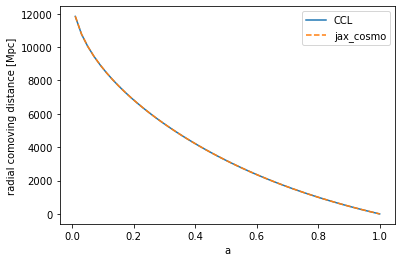

In [4]:
# Testing the radial comoving distance
chi_ccl = ccl.comoving_radial_distance(cosmo_ccl, a)
chi_jax = background.radial_comoving_distance(cosmo_jax, a)/cosmo_jax.h

plot(a, chi_ccl, label='CCL')
plot(a, chi_jax, '--', label='jax_cosmo')
legend()
xlabel('a')
ylabel('radial comoving distance [Mpc]')

Text(0, 0.5, 'angular comoving distance [Mpc]')

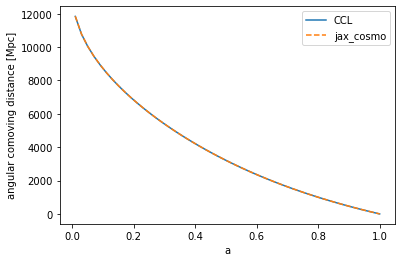

In [5]:
# Testing the angular comoving distance
chi_ccl = ccl.comoving_angular_distance(cosmo_ccl, a)
chi_jax = background.transverse_comoving_distance(cosmo_jax, a)/cosmo_jax.h

plot(a, chi_ccl, label='CCL')
plot(a, chi_jax, '--', label='jax_cosmo')
legend()
xlabel('a')
ylabel('angular comoving distance [Mpc]')

Text(0, 0.5, 'angular diameter distance [Mpc]')

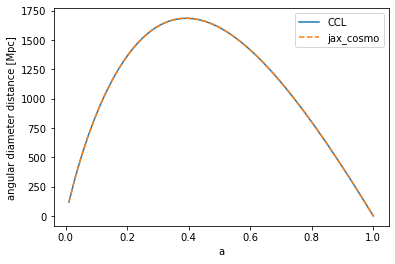

In [6]:
# Testing the angular diameter distance
chi_ccl = ccl.angular_diameter_distance(cosmo_ccl, a)
chi_jax = background.angular_diameter_distance(cosmo_jax, a)/cosmo_jax.h

plot(a, chi_ccl, label='CCL')
plot(a, chi_jax, '--', label='jax_cosmo')
legend()
xlabel('a')
ylabel('angular diameter distance [Mpc]')

Text(0, 0.5, 'Growth factor')

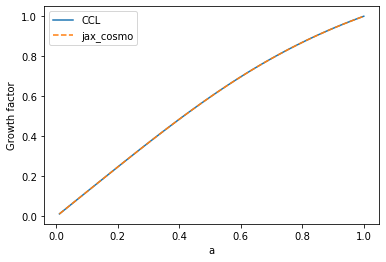

In [7]:
# Comparing the growth factor
plot(a, ccl.growth_factor(cosmo_ccl,a), label='CCL')
plot(a, background.growth_factor(cosmo_jax, a), '--', label='jax_cosmo')
legend()
xlabel('a')
ylabel('Growth factor')

## Comparing matter power spectrum

In [8]:
from jax_cosmo.power import linear_matter_power

In [9]:
k = np.logspace(-3,-0.5)

Text(0, 0.5, 'pk')

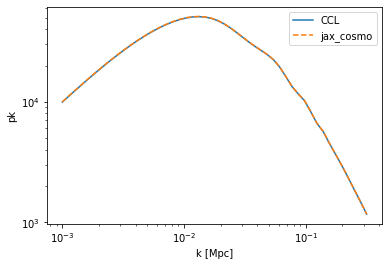

In [10]:
#Let's have a look at the linear power
pk_ccl = ccl.linear_matter_power(cosmo_ccl, k, 1.0)
pk_jax = linear_matter_power(cosmo_jax, k/cosmo_jax.h, a=1.0)

loglog(k,pk_ccl,label='CCL')
loglog(k,pk_jax/cosmo_jax.h**3, '--', label='jax_cosmo')
legend()
xlabel('k [Mpc]')
ylabel('pk')

## Comparing angular cl

In [11]:
from jax_cosmo.redshift import smail_nz

# Let's define a redshift distribution
# with a Smail distribution with a=1, b=2, z0=1
nz = smail_nz(1.,2., 1.)

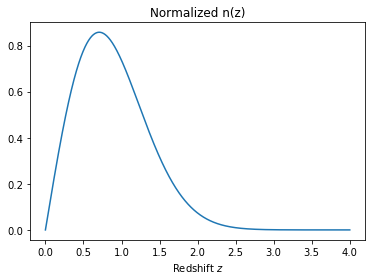

In [12]:
z = linspace(0,4,1024)
plot(z, nz(z))
xlabel(r'Redshift $z$');
title('Normalized n(z)');

In [13]:
from jax_cosmo.angular_cl import angular_cl
from jax_cosmo import probes

# Let's first compute some Weak Lensing cls
tracer_ccl = ccl.WeakLensingTracer(cosmo_ccl, (z, nz(z)), use_A_ia=False)
tracer_jax = probes.WeakLensing([nz])

ell = np.logspace(0.1,3)

cl_ccl = ccl.angular_cl(cosmo_ccl, tracer_ccl, tracer_ccl, ell)
cl_jax = angular_cl(cosmo_jax, ell, [tracer_jax])

Text(0, 0.5, 'Lensing angular $C_\\ell$')

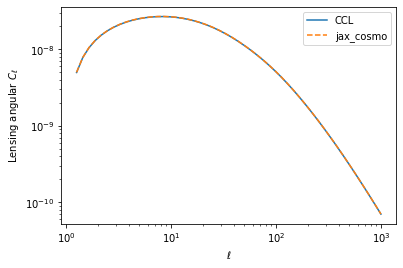

In [14]:
loglog(ell, cl_ccl,label='CCL')
loglog(ell, cl_jax[0], '--', label='jax_cosmo')

legend()
xlabel(r'$\ell$')
ylabel(r'Lensing angular $C_\ell$')

In [15]:
# Let's try galaxy clustering now
from jax_cosmo.bias import constant_linear_bias

# We define a trivial bias model
bias = constant_linear_bias(1.)

tracer_ccl_n = ccl.NumberCountsTracer(cosmo_ccl,
                                      has_rsd=False,
                                      dndz=(z, nz(z)),
                                      bias=(z, bias(cosmo_jax, z)))
tracer_jax_n = probes.NumberCounts([nz], bias)

cl_ccl = ccl.angular_cl(cosmo_ccl, tracer_ccl_n, tracer_ccl_n, ell)
cl_jax = angular_cl(cosmo_jax, ell, [tracer_jax_n])

Text(0, 0.5, 'Clustering angular $C_\\ell$')

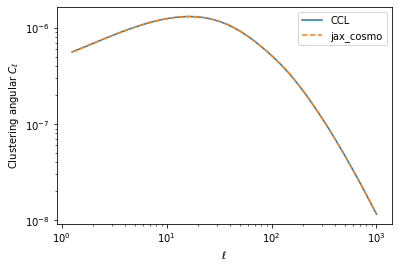

In [16]:
import jax_cosmo.constants as cst
loglog(ell, cl_ccl,label='CCL')
loglog(ell, cl_jax[0], '--', label='jax_cosmo')

legend()
xlabel(r'$\ell$')
ylabel(r'Clustering angular $C_\ell$')

In [17]:
# And  finally.... a cross-spectrum

cl_ccl = ccl.angular_cl(cosmo_ccl, tracer_ccl, tracer_ccl_n, ell)
cl_jax = angular_cl(cosmo_jax, ell, [tracer_jax, tracer_jax_n])

Text(0, 0.5, 'shape-position angular $C_\\ell$')

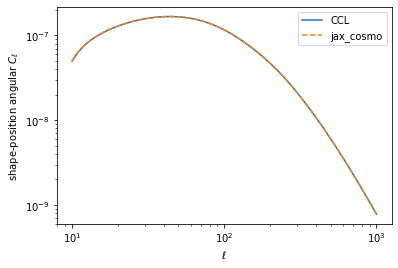

In [18]:
ell = np.logspace(1,3)

loglog(ell, cl_ccl,label='CCL')
loglog(ell, cl_jax[1], '--', label='jax_cosmo')

legend()
xlabel(r'$\ell$')
ylabel(r'shape-position angular $C_\ell$')